# Get Population Data from Google Earth Engine using GEEMap

In [1]:
import ee
import geemap

## Authenticate & Initialize GEE

Requires a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and to enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. Find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [2]:
ee.Initialize()

## Create a GEEMap Object

In [43]:
# center over Africa
m = geemap.Map(
    center=[0, 10], 
    zoom=4, 
    basemap = 'Esri.WorldImagery',
    height = 800
)
m

Map(center=[0, 10], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [8]:
# get the current zoom and center of map
print(m.center, m.zoom)

[0, 10.019531250000002] 4.0


## Add Layers to the Map

In [44]:
# add WorldPop population density layer
# https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description
dataset_pop = ee.ImageCollection('WorldPop/GP/100m/pop') \
                  .filter(ee.Filter.date('2020-01-01', '2020-12-31'))
pop = dataset_pop.select('population')
image_pop = pop.median()
popVis = {
    'min': 0.0, 
    'max': 20.0,
    'palette': ['24126c', '1fff4f', 'd4ff50'],
    'opacity': 0.5
}
m.addLayer(image_pop, popVis, 'Population')


In [45]:
# add place names
# https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0
m.add_basemap('CartoDB.VoyagerOnlyLabels')
# m.remove_layer('CartoDB.VoyagerOnlyLabels') # doesn't work

## Import CLUB-ER Sites

In [46]:
import pandas as pd
import geopandas as gpd

## Clean Up GeoDataFrames

In [47]:
# read back in the geojsons
cluber_gdf = gpd.read_file('data/cluber/cluber_sites.geojson')


# export into pop_africa folder
cluber_gdf.to_file('data/pop_africa/cluber_sites.geojson', driver='GeoJSON')

cluber_gdf.head(5)

,source,site_name,developer,country,longitude,latitude,status,date_commissioned,customers,geometry
0,CLUBER,Andulo,Unkonwn,Angola,16.694,-11.484,Unknown,2018-01-01,2000,POINT (16.69400 -11.48400)
1,CLUBER,Bailundo,Unkonwn,Angola,15.841,-12.190,Operating,2013-01-01,0,POINT (15.84100 -12.19000)
2,CLUBER,Wako Kungo,Unkonwn,Angola,15.120,-11.361,Operating,2013-01-01,0,POINT (15.12000 -11.36100)
3,CLUBER,Cunene,Unkonwn,Angola,14.970,-16.751,Operating,2013-01-01,0,POINT (14.97000 -16.75100)
4,CLUBER,Soyo,Unkonwn,Angola,12.352,-6.141,Operating,2013-01-01,0,POINT (12.35200 -6.14100)


## Get Countries in CLUB-ER Dataset

In [71]:
# get countries of CLUB-ER Sites
cluber_countries = cluber_gdf['country'].unique()

# rename DR Congo to Democratic Republic of the Congo
cluber_countries = [x if x != 'DR Congo' else 'Democratic Republic of the Congo' for x in cluber_countries]
# rename Tanzania to United Republic of Tanzania
cluber_countries = [x if x != 'Tanzania' else 'United Republic of Tanzania' for x in cluber_countries]

print('Club-ER Countries: ', cluber_countries)
# print length of cluber countries
print('Number of Club-ER Countries: ', len(cluber_countries))

# overlay country boundaries with white borders
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
# create a fc of just the countries in all_minigrid_countries
cluber_countries_fc = countries.filter(ee.Filter.inList('ADM0_NAME', cluber_countries))

# add cluber countries to map
m.addLayer(cluber_countries_fc, {'color': 'white'}, 'CLUB-ER Countries')

Club-ER Countries:  ['Angola', 'Burkina Faso', 'Cameroon', 'Democratic Republic of the Congo', 'Ethiopia', 'Ghana', 'Kenya', 'Liberia', 'Madagascar', 'Mali', 'Mauritania', 'Mozambique', 'Senegal', 'United Republic of Tanzania', 'Togo', 'Uganda', 'Zambia', 'Zimbabwe']
Number of Club-ER Countries:  18


In [66]:
# read in lookup table for country codes
# country_codes = pd.read_csv('data/pop_africa/country_codes.csv')

# pull in countries from restcountries.com
import requests
import json
url = 'https://restcountries.com/v3.1/all'
response = requests.get(url)
countries_json = json.loads(response.text)

# convert json to pandas dataframe
country_df = pd.json_normalize(countries_json)

# keep just the columns we need
country_df = country_df[['name.common','name.official','cca3', 'cca2', 'ccn3', 'region', 'subregion', 'latlng']]

# export to csv
country_df.to_csv('data/pop_africa/country_codes.csv', index=False)

In [73]:
# read in country_codes.csv
country_df = pd.read_csv('data/pop_africa/country_codes.csv')

# change the official names back to common names in cluber_countries
cluber_countries = ['DR Congo' if x == 'Democratic Republic of the Congo' else x for x in cluber_countries]
cluber_countries = ['Tanzania' if x == 'United Republic of Tanzania' else x for x in cluber_countries]

# filter down to countries in cluber_countries by name.official
cluber_country_codes = country_df[country_df['name.common'].isin(cluber_countries)]
cluber_country_codes_list = cluber_country_codes['cca3'].tolist()
cluber_country_codes


,name.common,name.official,cca3,cca2,ccn3,region,subregion,latlng
2,Liberia,Republic of Liberia,LBR,LR,430.0,Africa,Western Africa,"[6.5, -9.5]"
7,Zambia,Republic of Zambia,ZMB,ZM,894.0,Africa,Eastern Africa,"[-15.0, 30.0]"
17,Kenya,Republic of Kenya,KEN,KE,404.0,Africa,Eastern Africa,"[1.0, 38.0]"
20,Senegal,Republic of Senegal,SEN,SN,686.0,Africa,Western Africa,"[14.0, -14.0]"
32,Ghana,Republic of Ghana,GHA,GH,288.0,Africa,Western Africa,"[8.0, -2.0]"
38,Ethiopia,Federal Democratic Republic of Ethiopia,ETH,ET,231.0,Africa,Eastern Africa,"[8.0, 38.0]"
51,Cameroon,Republic of Cameroon,CMR,CM,120.0,Africa,Middle Africa,"[6.0, 12.0]"
55,Mali,Republic of Mali,MLI,ML,466.0,Africa,Western Africa,"[17.0, -4.0]"
127,Uganda,Republic of Uganda,UGA,UG,800.0,Africa,Eastern Africa,"[1.0, 32.0]"
137,Madagascar,Republic of Madagascar,MDG,MG,450.0,Africa,Eastern Africa,"[-20.0, 47.0]"


## Get Population Values for Sites

In [75]:
# fetch entire worldpop image collection on the ee server
worldpop = ee.ImageCollection("WorldPop/GP/100m/pop")

# filter to countries in cluber_country_codes in the column cca3
cluber_countries_codes = cluber_country_codes['cca3'].tolist()
worldpop_cluber = worldpop.filter(ee.Filter.inList('country', cluber_countries_codes))

# get the list of countries still in the collection
worldpop_cluber_countries = worldpop_cluber.aggregate_array('country').getInfo()
# show just the unique values
worldpop_cluber_countries = list(set(worldpop_cluber_countries))
print('WorldPop Countries: ', worldpop_cluber_countries)

WorldPop Countries:  ['MDG', 'COD', 'KEN', 'SEN', 'TGO', 'TZA', 'ZMB', 'BFA', 'ETH', 'LBR', 'MLI', 'MOZ', 'MRT', 'UGA', 'CMR', 'ZWE', 'GHA', 'AGO']


##########
Merge the images, sample them, get population values, re-run DinD
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################
########################################################################################

########################################################################################
########################################################################################
########################################################################################
########################################################################################

In [33]:
# recreate feature collection from geojson file
cluber_fc = geemap.geojson_to_ee('data/sl_pop/sl.geojson')

# create 1km buffer around each site
# todo consider a 2km buffer
cluber_fc_buffer = cluber_fc.map(lambda f: f.buffer(1000))

In [52]:
# fetch a lookup table of full country names and 3-letter country codes
country_codes = pd.read_csv('data/pop_africa/country_codes.csv')

In [ ]:

# filter down just to countries in cluber_countries
worldpop_cluber = worldpop.filterBounds(cluber_countries_fc)

# convert the worldpop_cluber image collection into a single image with one band for each year
worldpop_cluber = worldpop_cluber.select('population')
worldpop_cluber_stack = worldpop_cluber.toBands()

# print the worldpop_cluber_stack image
worldpop_cluber_stack

In [33]:
# we can use the reduceRegions function to calculate the sum of the population within each buffer
# calculate the sum of the population within each buffer for every image "band"
sl_pop_fc = worldpop_sl_stack.reduceRegions(
    collection=sl_fc_buffer,
    reducer=ee.Reducer.sum(),
)

# convert the cicular buffers back to points
sl_pop_fc = sl_pop_fc.map(lambda feature: feature.centroid())

In [41]:
# export the feature collection to a geopandas dataframe
sl_pop_gdf = geemap.ee_to_geopandas(sl_pop_fc)

# replace all column names containing 'SLE_' with ''
sl_pop_gdf.columns = sl_pop_gdf.columns.str.replace('SLE_', '')
sl_pop_gdf.columns = sl_pop_gdf.columns.str.replace('_population', '')

# export the geopandas dataframe to a geojson file
sl_pop_gdf.to_file('data/sl_pop/sl_pop.geojson', driver='GeoJSON')

### Clean Up and Melt the DataFrame

In [42]:
# read in the geojson as gdf
sl_pop_gdf = gpd.read_file('data/sl_pop/sl_pop.geojson')
gdf = sl_pop_gdf

# melt the dataframe
gdf = gdf.melt(id_vars=['site_name', 'date_commissioned', 'site_type', 'geometry'], var_name='year', value_name='population')

# round the population column to integers
gdf['population'] = gdf['population'].round().astype(int)

# convert the year column to datetime
gdf['year'] = pd.to_datetime(gdf['year'], format='%Y')

# export the dataframe to a csv
gdf.to_file('data/sl_pop/sl_pop_melt.geojson', driver='GeoJSON')

## Visualize the Results

In [39]:
# plot the population of each site over time
import matplotlib.pyplot as plt
import seaborn as sns


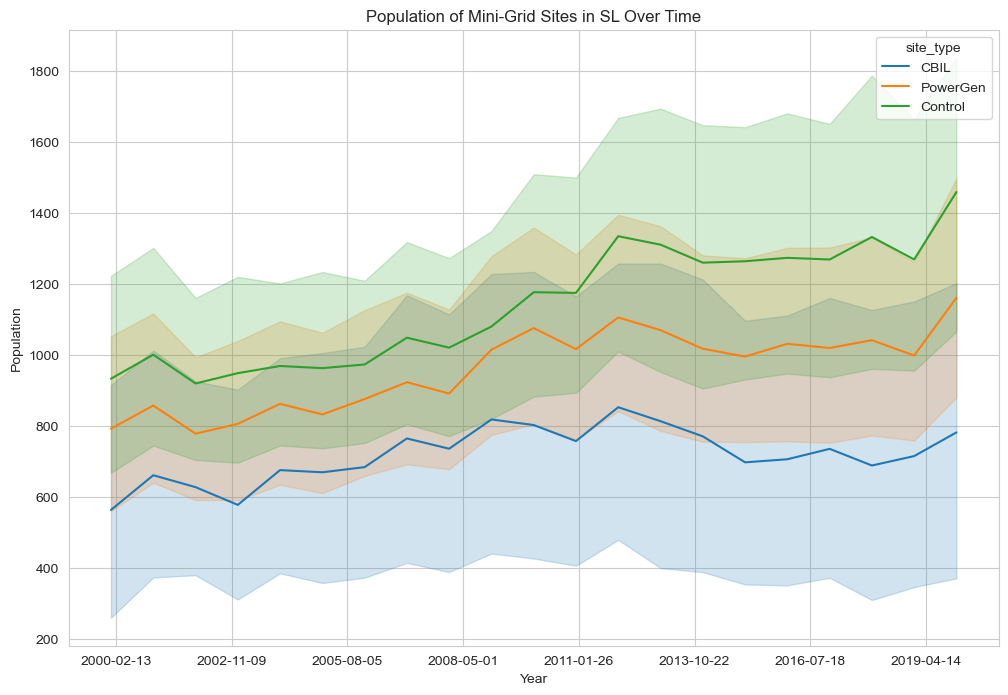

In [40]:
# import the gdf pop data
gdf = gpd.read_file('data/sl_pop/sl_pop_melt.geojson')

# set the style
sns.set_style('whitegrid')

# create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# plot the population of each site over time
sns.lineplot(data=gdf, x='year', y='population', hue='site_type', ax=ax)

# set the title
ax.set_title('Population of Mini-Grid Sites in SL Over Time')

# set the x-axis label
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# set the y-axis label
ax.set_ylabel('Population')

# show the plot
plt.show()